# Sea-ice Sensitivity & Ice-Free Timing vs. Satellite Product

## Setup

### Import Libraries

In [ ]:
# General imports
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Data handling
import xarray as xr
import pandas as pd

# Statistical analysis
from statsmodels.regression.linear_model import yule_walker
from scipy.stats import gaussian_kde

# Custom modules
import functions.helper as hlp
import functions.siametadata as meta
import functions.emulator_func as em
import functions.memberhandling as mbhl

from functions.custom_logger_functions import *

In [2]:
basepath = "/Users/quraus001/Documents/Uni/SIA-Sensitivity-Uncertainty/"

datapath = basepath + "data/"
plotpath = basepath + "plots/obs/"

save_plots = False

## Load Data

In [3]:
# observed CO2 data (Global Carbon Project)
df_co2 = pd.read_csv(datapath + "co2/CO2_historical_global-carbon-budget_cum.csv", index_col="Year") 

# sea-ice area (UHH-SIA)
file   = "SIA_observations_nh_v2025_fv0.01_nsidc_osisaf.nc" 
ds_sia = xr.open_dataset(datapath + file)
df_sia = ds_sia.sel(time=ds_sia['time'].dt.month == 9).to_dataframe() # select September data
df_sia.index = df_sia.index.year # convert datetime index to years
df_sia = df_sia.loc[1979:2024]   # limit to satellite era
df_sia = df_sia.drop(columns=['nsidc_cdr'])
names  = {"nsidc_bt": "Bootstrap", "nsidc_nt":"NASA-Team", "osisaf":"OSI SAF", "walsh":"Walsh"}

# GMST data (Berkeley Earth, GISSTEMPv4, NOAA, HadCRUT4)
df_gmst = pd.read_csv(f"{datapath}GMST/GMST_anomaly-1951-1980_GISSTEMPv4-BerkeleyEarth-NOAA-HadCRUT4-Kadow.csv", 
                      comment="#", sep=",", skipinitialspace=True, 
                      names=["Year", "BerkeleyEarth", "GISSTEMPv4", "NOAA", "HadCRUT4", "Kadow", "NOAA_rebased", "HadCRUT4_rebased", "Kadow_rebased"])
df_gmst.set_index("Year", inplace=True)  # convert time index to years

# Load CMIP6 CO2 emissions data and compute cumulative sum
ds_cmip6 = xr.open_dataset(datapath + "co2/CMIP6_co2_emissions_ssp.nc")
df_co2_cmip6 = ds_cmip6.to_dataframe().cumsum(axis=0)
#df_co2_cmip6.index = df_co2_cmip6.index.year.astype(int)
df_co2.index = df_co2.index.astype(int)

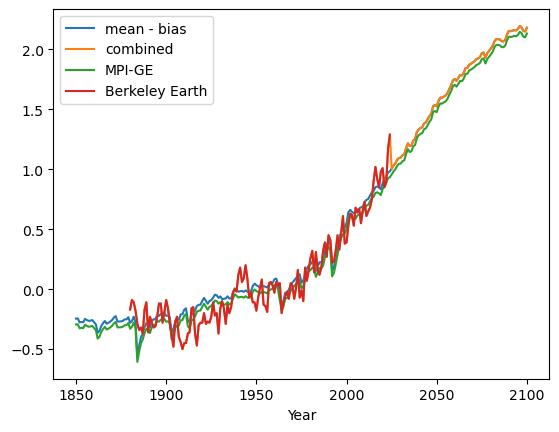

In [4]:
start, stop = 2000, 2024

df_45_mpige_gmst = mbhl.load_model_data(inpath=datapath + "MPI-ESM2-1-LR/gmst/", scenario="ssp245")
df_45_mpige_gmst = df_45_mpige_gmst[["mean"]] - 273.15                          # convert from K to °C  
df_45_mpige_gmst = df_45_mpige_gmst - np.mean(df_45_mpige_gmst.loc[1951:1980])  # calculate anomalies: remove 1951-1980 mean

bias = np.mean(df_45_mpige_gmst["mean"].loc[start:stop] - df_gmst["BerkeleyEarth"].loc[start:stop])

gmst_long = df_45_mpige_gmst["mean"]-bias
# Ensure the right dtype and shape
gmst_long = gmst_long.astype(np.float64) 
# Extend the index to cover the full range
gmst_long.loc[:stop] = df_gmst["BerkeleyEarth"].loc[1850:stop].values.astype(gmst_long.dtype)

plt.plot(df_45_mpige_gmst.index, df_45_mpige_gmst["mean"]-bias, label="mean - bias")
plt.plot(df_45_mpige_gmst.index, gmst_long, label="combined")
df_45_mpige_gmst["mean"].plot(label="MPI-GE")
df_gmst["BerkeleyEarth"].plot(label="Berkeley Earth")
plt.legend()
plt.show()


## Look at some specs

In [5]:
start, stop = 1979, 2024
products = ['nsidc_bt', 'nsidc_nt', 'osisaf']

AR1_coeff = []
Sigmas    = []
Sens      = []
print(f"{start} - {stop}")
print(f"                S,     ϕ,     σ,     ΔS,  correlation") # print Sensitivity, AR1 coeff, Std. dev. of residuals, 2 *Std. dev. of sensitivity for white noise, first ice-free timing 

for product in products:
    print()
    co2 = df_co2.loc[start: stop]["both_cum"]
    sia = df_sia.loc[start:stop][product]

    obs_sens, y_pred, lin_timing, intercept, std_err, correlation = meta.get_meta_data_indepth(sia, co2)
    residuals = sia - y_pred
    sigma = np.std(residuals)
    rho = yule_walker(residuals, order=1)[0][0]
    rho = rho + ((1+4*rho)/len(residuals))

    print(f"{names[product].ljust(10)}   {obs_sens:.3f}, {rho:.3f}, {sigma:.3f}, {2*std_err*1e3:.3f}, {correlation:.3f}")

    AR1_coeff.append(rho.item())
    Sigmas.append(sigma)
    Sens.append(obs_sens)
print()
print(f"mean         {np.nanmean(Sens):.3f}, {np.mean(AR1_coeff):.3f}, {np.nanmean(Sigmas):.3f}")


1979 - 2024
                S,     ϕ,     σ,     ΔS,  correlation

Bootstrap    -2.425, 0.206, 0.484, 0.329, -0.912

NASA-Team    -2.175, 0.293, 0.429, 0.292, -0.914

OSI SAF      -2.142, 0.275, 0.435, 0.296, -0.909

mean         -2.247, 0.258, 0.450


## Plotting Functions

In [6]:
def create_year_axis(ax, co2, co2_name="both_cum", xmin=600, xmax=2600, distance=-0.15, newlabel=None):
    """
    Adds a secondary x-axis to a plot, converting cumulative CO₂ emissions to corresponding calendar years.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The primary matplotlib axis to which the secondary axis will be added.
    co2 : pandas.DataFrame
        A DataFrame containing CO₂ data, with years as the index and cumulative emissions as one of the columns.
    co2_name : str, default "both_cum"
        The column name in `co2` that contains the cumulative emissions values.
    xmin : float, default 600
        The minimum value of the x-axis (in cumulative CO₂ units).
    xmax : float, default 2600
        The maximum value of the x-axis (in cumulative CO₂ units).
    distance : float, default -0.15
        Vertical offset for the secondary x-axis (in axis-relative coordinates).
    newlabel : list of int, optional
        A list of years to label on the secondary axis. If None, defaults to [1960, 1980, 1990, 2000, 2010, 2020].

    Returns
    -------
    matplotlib.axes.Axes
        The new secondary x-axis (`ax2`) with year labels corresponding to cumulative emissions.
    """
    ax2 = ax.twiny()

    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", distance))
    if newlabel is None:
        newlabel = [1960, 1980, 1990, 2000, 2010, 2020]
    newpos   = [co2.loc[i][co2_name] for i in newlabel]
    ax2.set_xticks(newpos)
    ax2.set_xticklabels(newlabel)
    ax2.set_xlim(xmin, xmax)
    ax.set_xlim(xmin, xmax)
    ax2.set_xlabel("Year")

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    return ax2


def plot_range_bars(ax, data, IPR, ypos, color, height=0.4, n_x=300):
    """
    Draw a horizontal bar at y=ypos with either:
    - a solid color bar (classic)
    - or a gradient based on the data's PDF (if gradient=True)

    Parameters:
    -----------
    ax : matplotlib axis
        Axis on which to draw.
    data : array-like
        Sample values to summarize with a bar.
    IPR : float
        Inner percentile range (e.g., 95.5).
    ypos : float
        Y-axis location for the center of the bar.
    color : str or RGB tuple
        Color for the bar and mean line.
    height : float
        Height of the bar in y-units.
    n_x : int
        Resolution of the gradient image (only used if gradient=True).
    """

    # Compute percentiles and mean
    lower = np.percentile(data, (100 - IPR) / 2)
    upper = np.percentile(data, 100 - (100 - IPR) / 2)
    mean = np.mean(data)
    rgb = mcolors.to_rgb(color)

    # Estimate PDF
    kde = gaussian_kde(data, bw_method=0.3)
    x = np.linspace(lower, upper, n_x)
    pdf = kde(x)
    pdf /= pdf.max()

    # Create RGBA image: horizontal gradient (shape: 1 x n_x x 4)
    rgba = np.zeros((1, n_x, 4))
    rgba[..., :3] = rgb
    rgba[...,  3] = pdf

    # Place image on plot
    y0 = ypos - height / 2
    im = ax.imshow(
        rgba,
        origin='lower',
        extent=(x[0], x[-1], y0, y0 + height),
        aspect='auto',
        interpolation='bicubic',
        zorder=2
    )

    # Clip the image to a rectangular region
    clip = Rectangle((x[0], y0), x[-1] - x[0], height, transform=ax.transData)
    im.set_clip_path(clip)

    # mean line
    ax.plot([mean, mean], [ypos - height / 2, ypos + height / 2],
            color=rgb, linewidth=3, zorder=3)

    # Optional IPR bounds (light lines)
    ax.plot([lower, lower], [ypos - height / 2, ypos + height / 2],
            color=rgb, alpha=0.3, lw=1, zorder=1)
    ax.plot([upper, upper], [ypos - height / 2, ypos + height / 2],
            color=rgb, alpha=0.3, lw=1, zorder=1)


## Printing Functions

In [7]:
def IPR_limits(data, IPR=95.5):
    """
    Calculate the upper and lower limits of the Inner Percentile Range (IPR) for the given data.

    Parameters
    ----------
    data : array-like
        The input data for which to calculate the IPR limits.
    IPR : float, optional
        The Inner Percentile Range to calculate (default is 95.5).

    Returns
    -------
    tuple
        A tuple containing the upper and lower limits of the IPR.
    """
    lower = np.percentile(data, (100 - IPR) / 2)
    upper = np.percentile(data, 100 - (100 - IPR) / 2)
    return(upper.item(), lower.item())

def printing_data(logger,data, IPR, var_str, data_source, product, convert_time=True, latex_dict=None):
    """
    Print mean, median, IPR limits and store in latex_dict.

    Parameters
    ----------
    logger : logging.Logger
        Logger for debug output.
    data : array-like
        The input data for which to calculate statistics.
    IPR : float
        The Inner Percentile Range to calculate.
    var_str : str
        Variable string for labeling.
    data_source : str
        Data source identifier. (produced with co2 or gmst forcing)
    product : str
        SIA satellite product identifier.
    convert_time : bool, optional
        Whether to convert CO2 values to years (default is True).
    latex_dict : dict. Default None.
        Dictionary to store formatted results.
    """
    mean, median, (upper, lower) = np.mean(data), np.median(data), IPR_limits(data, IPR)
    logger.debug(f"      {var_str}: {mean:1.3f}, {median:1.3f}, ({upper-mean:1.3f}, {lower-mean:1.3f}), ({upper:1.3f} {lower:1.3f})")

    if latex_dict is not None:
        if var_str in ["Lin ", "EM  "] and data_source=="co2":
            latex_dict[data_source][var_str][product] = f"{mean:1.0f} (+{upper-mean:1.0f}, {lower-mean:1.0f})"
        else:
            latex_dict[data_source][var_str][product] = f"{mean:1.2f} (+{upper-mean:1.2f}, {lower-mean:1.2f})"

    if convert_time:
        logger.debug(f"          years: {co2_to_year(mean):1.3f}, {co2_to_year(median):1.3f}, ({co2_to_year(upper):1.3f} {co2_to_year(lower):1.3f})")

def co2_to_year(co2_value, scenario="ssp245"):
    """
    Convert cumulative CO2 emissions to the closest corresponding calendar year.
    Parameters
    ----------
    co2_value : float
        The cumulative CO2 emissions value to convert.
    scenario : str, optional
        The scenario to use for the conversion (default is "ssp245").

    Returns
    -------
    int
        The closest corresponding calendar year.
    """
    closest_year = df_co2_cmip6[scenario].sub(co2_value).abs().idxmin()
    return closest_year
    

## Main Code Fig.4

In [8]:
def create_latex_dict():
    """
    Create a nested dictionary structure for storing results for LaTeX template.

    Returns
    -------
    dict
        A nested dictionary with keys for data sources and variable strings.
    """
    latex_dict = {"co2":{}, "gmst":{}}

    for data_source in ["co2", "gmst"]:
        latex_dict[data_source] = {"Sens":{}, "Lin ":{}, "EM  ":{}}

    for var in latex_dict[data_source].keys():
        latex_dict[data_source][var] = {'nsidc_bt':None, 'nsidc_nt':None, 'osisaf':None, "combined":None}

    return latex_dict

Running co2 for timeperiod [1979, 2024]
-----------------------
   nsidc_bt
      Sens: -2.424, -2.424, (0.421, -0.421), (-2.003 -2.845)
      Lin : 3805.516, 3790.293, (399.862, -309.845), (4205.378 3495.672)
          years: 2052.000, 2051.000, (2061.000 2044.000)
      EM  : 3641.200, 3632.943, (252.011, -316.366), (3893.211 3324.833)
          years: 2048.000, 2048.000, (2054.000 2041.000)
   nsidc_nt
      Sens: -2.174, -2.174, (0.412, -0.412), (-1.762 -2.587)
      Lin : 3456.744, 3442.738, (370.111, -278.257), (3826.855 3178.487)
          years: 2044.000, 2043.000, (2052.000 2037.000)
      EM  : 3301.379, 3324.833, (287.786, -327.772), (3589.165 2973.607)
          years: 2040.000, 2041.000, (2047.000 2033.000)
   osisaf
      Sens: -2.142, -2.142, (0.409, -0.409), (-1.734 -2.551)
      Lin : 3729.226, 3712.013, (429.943, -325.505), (4159.169 3403.721)
          years: 2050.000, 2049.000, (2060.000 2042.000)
      EM  : 3562.687, 3589.165, (287.715, -326.126), (3850.402 3236.5

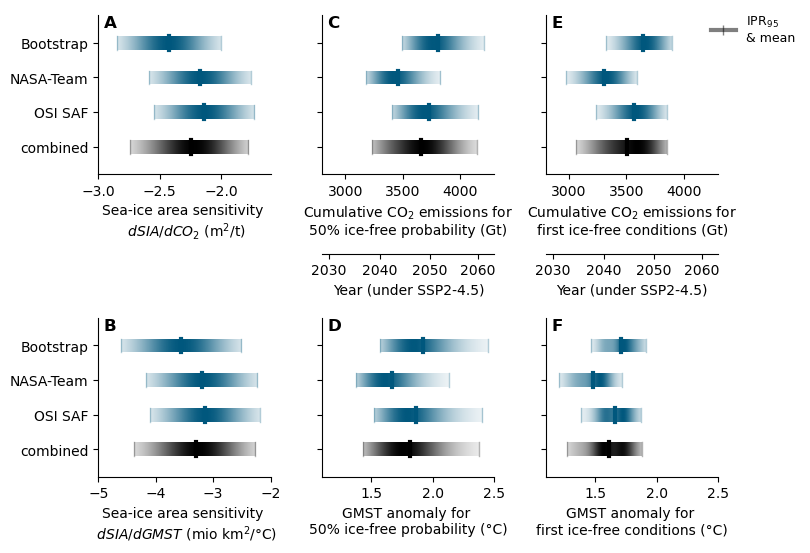

In [10]:
# Main code parameters
runs= 100000
IPR = 95.5
noise = "ar1"
scenario  = "ssp245"
timeperiod = [1979, 2024]
loglevel = "debug"

# Set random seed for reproducibility
np.random.seed(1)

# Define SIA and GMST products
sia_products  = ['nsidc_bt', 'nsidc_nt', 'osisaf']
gmst_products = ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']

# Y-axis locations for bars
y_locs = [4,3,2,1] 

# Build logger
logger = build_terminal_logger(loglevel.upper(), "uncertainty-bars")

# Create LaTeX dictionary
latex_dict = create_latex_dict()

# Create figure and axes
fig, axs = plt.subplots(2, 3, figsize=(8, 6), sharey=True)#, constrained_layout=True)
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# Add panel letters
letters = ["A", "B", "C", "D", "E", "F"]
for ax, letter in zip(axs.T.ravel(), letters):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12)

# Define function to run emission block
def run_emission_block(axs_row, data_source, co2_name, df_co2_long, xmin_sens, xmax_sens, xmin_timing, xmax_timing, y_locs):
    
    logger.info(f"Running {data_source} for timeperiod {str(timeperiod)}")
    logger.info("-----------------------")

    start, stop = timeperiod
    color = "#00577d"
    SENS, LIN, EM = [], [], []

    # Loop over SIA products
    for i, product in enumerate(sia_products):
        logger.debug(f"   {product}")
        # Run experiments
        if data_source == "co2":
            convert_time = True
            Sensitivities, *_, Lin_timing, _, Em_timing = em.experiment_indepth_long(df_sia, df_co2, runs, noise, start, stop, product, co2_name="both_cum", prediction_end=2100, df_co2_long=df_co2_cmip6["ssp245"], phi_correction=True)
        elif data_source == "gmst":
            Sensitivities, Lin_timing, Em_timing = [], [], []
            reduced_runs = int(runs/len(gmst_products)) # divide runs among GMST products
            convert_time = False # dont convert to time since GMST is not monotonically increasing
            for gmst_product in gmst_products:
                sensitivities, *_, lin_timing,_,  em_timing = em.experiment_indepth_long(df_sia, df_gmst, reduced_runs, noise, start, stop, product, co2_name=gmst_product, prediction_end=2100, df_co2_long=gmst_long, phi_correction=True, co2_units=False)
                Sensitivities += sensitivities
                Lin_timing += lin_timing
                Em_timing += em_timing

        plot_range_bars(axs_row[0], Sensitivities, IPR, y_locs[i], color)
        plot_range_bars(axs_row[1], Lin_timing, IPR, y_locs[i], color)
        plot_range_bars(axs_row[2], Em_timing, IPR, y_locs[i], color)

        printing_data(logger, Sensitivities, IPR, "Sens", data_source, product, convert_time=False, latex_dict=latex_dict)
        printing_data(logger, Lin_timing, IPR, "Lin ", data_source, product, convert_time=convert_time, latex_dict=latex_dict)
        printing_data(logger, Em_timing, IPR, "EM  ", data_source, product, convert_time=convert_time, latex_dict=latex_dict)

        # Save for combined
        SENS += Sensitivities
        LIN += Lin_timing
        EM += Em_timing

    # combined
    plot_range_bars(axs_row[0], SENS, IPR, y_locs[-1], "black")
    plot_range_bars(axs_row[1], LIN, IPR, y_locs[-1], "black")
    plot_range_bars(axs_row[2], EM, IPR, y_locs[-1], "black")

    logger.debug("   combined")
    logger.debug(f"     {data_source}, {timeperiod}, {product}")
    printing_data(logger, SENS, IPR, "Sens", data_source, "combined", convert_time=False, latex_dict=latex_dict)
    printing_data(logger, LIN, IPR, "Lin ", data_source, "combined", convert_time=convert_time, latex_dict=latex_dict)
    printing_data(logger, EM, IPR, "EM  ", data_source, "combined", convert_time=convert_time, latex_dict=latex_dict)

    # axis formatting, labels
    axs_row[0].set_xlim(xmin_sens, xmax_sens)
    axs_row[1].set_xlim(xmin_timing, xmax_timing)
    axs_row[2].set_xlim(xmin_timing, xmax_timing)

    logger.info("Finished run_emission_block\n")


# Run both
run_emission_block((ax1, ax2, ax3), "co2", "both_cum", df_co2_cmip6["ssp245"], -3, -1.6, 2800, 4300, y_locs)
run_emission_block((ax4, ax5, ax6), "gmst", "GMST", gmst_long, -5, -2, 1.1, 2.5, y_locs)

# Set satellite products as y-ticks
ax1.set_yticks([1, 2, 3, 4], ["combined", names['osisaf'], names['nsidc_nt'], names['nsidc_bt']])

# Build legend
integer_part = int(IPR)
subscript_str = ''.join(f"$_{digit}$" for digit in str(integer_part))
legend_elements = [Line2D([0], [0], color="black", linestyle="-", label=f"IPR{subscript_str} \n& mean", marker="|", markersize=7, lw=3, alpha=0.5)]
fig.legend(loc='upper right', handles=legend_elements, frameon=False, fontsize=9, bbox_to_anchor=(1.01, 0.9), bbox_transform=fig.transFigure)

# Add year axes
for ax in [ax2, ax3]:
    ax_co2 = create_year_axis(ax, df_co2_cmip6, co2_name="ssp245", xmin=2800, xmax=4300, distance=-0.5, newlabel=[2030, 2040, 2050, 2060])
    ax_co2.set_xlabel("Year (under SSP2-4.5)")

# Format all axes
for ax in axs.flatten():
    ax.set_ylim(0.2, 4.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-labels
ax1.set_xlabel("Sea-ice area sensitivity \n $dSIA/dCO_2$ (m$^2$/t)")
ax2.set_xlabel("Cumulative CO$_2$ emissions for \n50% ice-free probability (Gt)")
ax3.set_xlabel("Cumulative CO$_2$ emissions for \nfirst ice-free conditions (Gt)")

ax4.set_xlabel("Sea-ice area sensitivity \n $dSIA/dGMST$ (mio km$^2$/°C)")
ax5.set_xlabel("GMST anomaly for \n50% ice-free probability (°C)")
ax6.set_xlabel("GMST anomaly for \nfirst ice-free conditions (°C)")

# increase vertical space between rows
fig.subplots_adjust(hspace=0.9)
fig.subplots_adjust(wspace=0.3)

hlp.save_plot(plotpath + f"bars_CO2_GMST_selectedproducts_2024", save_plots, ["png","pdf"])


In [14]:
forc = "gmst"

print(repr("& OSI SAF & Bootstrap & NASA Team& combined\\\hline"))

for var, var_str in zip(latex_dict[forc].keys(), ["Sensitivity (m$^2$/t)", repr("50\% ice-free (Gt)"), "first ice-free (Gt)"]):
    print(repr(f"{var_str}&  &  &  & \\"))
    osi = latex_dict[forc][var]["osisaf"]
    bt  = latex_dict[forc][var]["nsidc_bt"]
    nt  = latex_dict[forc][var]["nsidc_nt"]
    com = latex_dict[forc][var]["combined"]

    print(repr(f"{timeperiod} & {osi} & {bt} & {nt} & {com}\\"))


'& OSI SAF & Bootstrap & NASA Team& combined\\\\hline'
'Sensitivity (m$^2$/t)&  &  &  & \\'
'[1979, 2024] & -3.14 (+0.95, -0.96) & -3.56 (+1.05, -1.05) & -3.20 (+0.97, -0.97) & -3.30 (+1.03, -1.09)\\'
"'50\\\\% ice-free (Gt)'&  &  &  & \\"
'[1979, 2024] & 1.87 (+0.54, -0.34) & 1.92 (+0.53, -0.35) & 1.67 (+0.46, -0.30) & 1.82 (+0.55, -0.39)\\'
'first ice-free (Gt)&  &  &  & \\'
'[1979, 2024] & 1.66 (+0.21, -0.27) & 1.71 (+0.21, -0.24) & 1.48 (+0.24, -0.27) & 1.61 (+0.27, -0.34)\\'


## Repeat for White Noise

Running co2 for timeperiod [1979, 2024]
-----------------------
   nsidc_bt
      Sens: -2.424, -2.424, (0.336, -0.335), (-2.087 -2.759)
      Lin : 3799.871, 3790.309, (308.331, -252.202), (4108.202 3547.669)
          years: 2051.000, 2051.000, (2058.000 2045.000)
      EM  : 3627.957, 3632.943, (222.445, -303.123), (3850.402 3324.833)
          years: 2047.000, 2047.000, (2052.000 2040.000)
   nsidc_nt
      Sens: -2.175, -2.174, (0.300, -0.301), (-1.874 -2.476)
      Lin : 3449.749, 3442.551, (255.939, -208.579), (3705.688 3241.170)
          years: 2043.000, 2043.000, (2049.000 2038.000)
      EM  : 3282.706, 3280.658, (218.664, -309.099), (3501.371 2973.607)
          years: 2039.000, 2039.000, (2044.000 2032.000)
   osisaf
      Sens: -2.142, -2.142, (0.304, -0.304), (-1.838 -2.447)
      Lin : 3721.605, 3711.951, (305.437, -248.480), (4027.043 3473.125)
          years: 2049.000, 2049.000, (2057.000 2044.000)
      EM  : 3544.861, 3545.307, (262.405, -308.301), (3807.266 3236.5

plot was saved as: /Users/quraus001/Documents/Uni/Thesis/Paper/bars_CO2_GMST_selectedproducts_2024_white.png
plot was saved as: /Users/quraus001/Documents/Uni/Thesis/Paper/bars_CO2_GMST_selectedproducts_2024_white.pdf


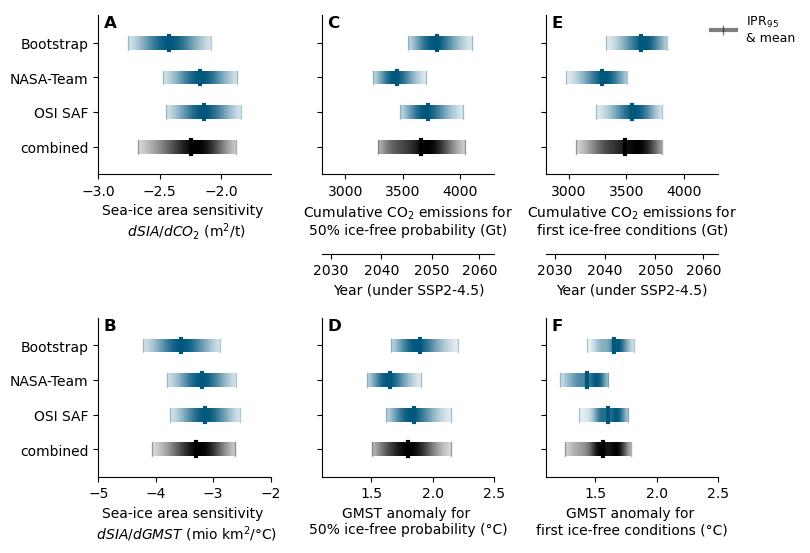

In [ ]:
# Main code parameters
runs= 100000
IPR = 95.5
noise = "white"
scenario  = "ssp245"
timeperiod = [1979, 2024]
loglevel = "debug"

# Set random seed for reproducibility
np.random.seed(1)

# Define SIA and GMST products
sia_products  = ['nsidc_bt', 'nsidc_nt', 'osisaf']
gmst_products = ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']

# Y-axis locations for bars
y_locs = [4,3,2,1] 

# Build logger
logger = build_terminal_logger(loglevel, "uncertainty-bars")

# Create figure and axes
fig, axs = plt.subplots(2, 3, figsize=(8, 6), sharey=True)#, constrained_layout=True)
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# Add panel letters
letters = ["A", "B", "C", "D", "E", "F"]
for ax, letter in zip(axs.T.ravel(), letters):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12)

# Run both
run_emission_block((ax1, ax2, ax3), "co2", "both_cum", df_co2_cmip6["ssp245"], -3, -1.6, 2800, 4300, y_locs)
run_emission_block((ax4, ax5, ax6), "gmst", "GMST", gmst_long, -5, -2, 1.1, 2.5, y_locs)

# Set satellite products as y-ticks
ax1.set_yticks([1, 2, 3, 4], ["combined", names['osisaf'], names['nsidc_nt'], names['nsidc_bt']])

# Build legend
integer_part = int(IPR)
subscript_str = ''.join(f"$_{digit}$" for digit in str(integer_part))
legend_elements = [Line2D([0], [0], color="black", linestyle="-", label=f"IPR{subscript_str} \n& mean", marker="|", markersize=7, lw=3, alpha=0.5)]
fig.legend(loc='upper right', handles=legend_elements, frameon=False, fontsize=9, bbox_to_anchor=(1.01, 0.9), bbox_transform=fig.transFigure)

# Add year axes
for ax in [ax2, ax3]:
    ax_co2 = create_year_axis(ax, df_co2_cmip6, co2_name="ssp245", xmin=2800, xmax=4300, distance=-0.5, newlabel=[2030, 2040, 2050, 2060])
    ax_co2.set_xlabel("Year (under SSP2-4.5)")

# Format all axes
for ax in axs.flatten():
    ax.set_ylim(0.2, 4.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-labels
ax1.set_xlabel("Sea-ice area sensitivity \n $dSIA/dCO_2$ (m$^2$/t)")
ax2.set_xlabel("Cumulative CO$_2$ emissions for \n50% ice-free probability (Gt)")
ax3.set_xlabel("Cumulative CO$_2$ emissions for \nfirst ice-free conditions (Gt)")

ax4.set_xlabel("Sea-ice area sensitivity \n $dSIA/dGMST$ (mio km$^2$/°C)")
ax5.set_xlabel("GMST anomaly for \n50% ice-free probability (°C)")
ax6.set_xlabel("GMST anomaly for \nfirst ice-free conditions (°C)")

# increase vertical space between rows
fig.subplots_adjust(hspace=0.9)
fig.subplots_adjust(wspace=0.3)

hlp.save_plot(plotpath + f"bars_CO2_GMST_selectedproducts_2024_white", save_plots, ["png","pdf"])


## GMST Product influence for OSI SAF

In [42]:
# Prepare LaTeX dictionary
latex_dict2 = {"co2":{}, "gmst":{}}

for data_source in ["co2", "gmst"]:
    latex_dict2[data_source] = {"Sens":{}, "Lin ":{}, "EM  ":{}}

    for var in latex_dict2[data_source].keys():
        latex_dict2[data_source][var] = {'nsidc_bt':None, 'nsidc_nt':None, 'osisaf':None, "combined":None}

Running BerkeleyEarth for timeperiod [1979, 2024]
-----------------------
      Sens: -3.113, -3.109, (0.917, -0.913), (-2.195 -4.026)
      Lin : 1.869, 1.838, (0.508, -0.334), (2.377 1.535)
      EM  : 1.661, 1.672, (0.212, -0.270), (1.873 1.391)
Running GISSTEMPv4 for timeperiod [1979, 2024]
-----------------------
      Sens: -3.067, -3.069, (0.942, -0.934), (-2.125 -4.001)
      Lin : 1.928, 1.896, (0.551, -0.344), (2.480 1.584)
      EM  : 1.711, 1.723, (0.201, -0.271), (1.912 1.440)
Running NOAA_rebased for timeperiod [1979, 2024]
-----------------------
      Sens: -3.162, -3.164, (1.032, -1.037), (-2.130 -4.199)
      Lin : 1.841, 1.805, (0.588, -0.356), (2.430 1.485)
      EM  : 1.623, 1.638, (0.216, -0.273), (1.839 1.350)
Running HadCRUT4_rebased for timeperiod [1979, 2024]
-----------------------
      Sens: -3.125, -3.121, (0.889, -0.897), (-2.236 -4.022)
      Lin : 1.864, 1.838, (0.489, -0.322), (2.353 1.542)
      EM  : 1.656, 1.669, (0.193, -0.243), (1.849 1.413)
Runni

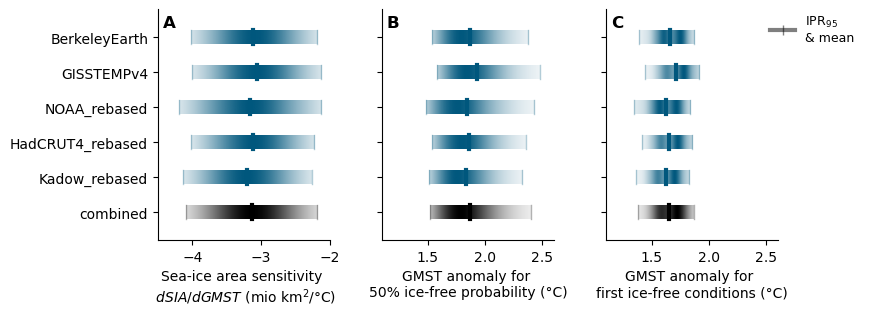

In [13]:
# Main code parameters
runs= 100000
IPR = 95.5
noise = "ar1"
scenario  = "ssp245"
timeperiod = [1979, 2024]
loglevel = "debug"

# Set random seed for reproducibility
np.random.seed(1)

# Define SIA and GMST products
sia_products  = ['nsidc_bt', 'nsidc_nt', 'osisaf']
gmst_products = ['BerkeleyEarth', 'GISSTEMPv4', 'NOAA_rebased', 'HadCRUT4_rebased', 'Kadow_rebased']

# Y-axis locations for bars
y_locs = [6, 5, 4, 3, 2, 1] 

# Build logger
logger = build_terminal_logger(loglevel, "uncertainty-bars")

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True)#, constrained_layout=True)
(ax1, ax2, ax3) = axs

# Add panel letters
letters = ["A", "B", "C"]
for ax, letter in zip(axs.ravel(), letters):
    ax.text(.03, .922, letter, fontweight="bold", transform=ax.transAxes, fontsize=12)

reduced_runs = int(runs/len(gmst_products)) # divide runs among GMST products
convert_time = False # dont convert to time since GMST is not monotonically increasing

SENS, LIN, EM = [], [], []


for i, gmst_product in enumerate(gmst_products):
    logger.info(f"Running {gmst_product} for timeperiod {str(timeperiod)}")
    logger.info("-----------------------")

    start, stop = timeperiod
    color = "#00577d"
    
    #sensitivities, *_, lin_timing,_,  em_timing = em_gmst.experiment_indepth_long("osisaf", df_gmst, df_sia, reduced_runs, noise, start, stop, co2_name=gmst_product, prediction_end=2100, df_co2_long=gmst_long, phi_correction=True)
    sensitivities, *_, lin_timing,_,  em_timing = em.experiment_indepth_long(df_sia, df_gmst, reduced_runs, noise, start, stop, "osisaf", co2_name=gmst_product, prediction_end=2100, df_co2_long=gmst_long, phi_correction=True, co2_units=False)

    plot_range_bars(ax1, sensitivities, IPR, y_locs[i], color)
    plot_range_bars(ax2, lin_timing, IPR, y_locs[i], color)
    plot_range_bars(ax3, em_timing, IPR, y_locs[i], color)

    printing_data(logger, sensitivities, IPR, "Sens", "gmst", product, convert_time=False)
    printing_data(logger, lin_timing, IPR, "Lin ", "gmst", product, convert_time=convert_time)
    printing_data(logger, em_timing, IPR, "EM  ", "gmst", product, convert_time=convert_time)

    SENS += sensitivities
    LIN += lin_timing
    EM += em_timing
 

# combined
plot_range_bars(ax1, SENS, IPR, y_locs[-1], "black")
plot_range_bars(ax2, LIN, IPR, y_locs[-1], "black")
plot_range_bars(ax3, EM, IPR, y_locs[-1], "black")

logger.debug("   combined")
logger.debug(f"     gmst, {timeperiod}, {product}")
printing_data(logger, SENS, IPR, "Sens", "gmst", "combined", convert_time=False)
printing_data(logger, LIN, IPR, "Lin ", "gmst", "combined", convert_time=convert_time)
printing_data(logger, EM, IPR, "EM  ", "gmst", "combined", convert_time=convert_time)

# axis formatting, labels
ax1.set_xlim(-4.5, -2)
ax2.set_xlim(1.1, 2.6)
ax3.set_xlim(1.1, 2.6)

# Set satellite products as y-ticks
ax1.set_yticks([1, 2, 3, 4, 5, 6], ["combined", gmst_products[4], gmst_products[3], gmst_products[2], gmst_products[1], gmst_products[0]])

# Build legend
integer_part = int(IPR)
subscript_str = ''.join(f"$_{digit}$" for digit in str(integer_part))
legend_elements = [Line2D([0], [0], color="black", linestyle="-", label=f"IPR{subscript_str} \n& mean", marker="|", markersize=7, lw=3, alpha=0.5)]
fig.legend(loc='upper right', handles=legend_elements, frameon=False, fontsize=9, bbox_to_anchor=(1.01, 0.9), bbox_transform=fig.transFigure)

# Format all axes
for ax in axs.flatten():
    ax.set_ylim(0.2, 6.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-labels
ax1.set_xlabel("Sea-ice area sensitivity \n $dSIA/dGMST$ (mio km$^2$/°C)")
ax2.set_xlabel("GMST anomaly for \n50% ice-free probability (°C)")
ax3.set_xlabel("GMST anomaly for \nfirst ice-free conditions (°C)")

# increase vertical space between rows
fig.subplots_adjust(hspace=0.9)
fig.subplots_adjust(wspace=0.3)

hlp.save_plot(plotpath + f"bars_GMST_osisaf_2024", save_plots, ["png","pdf"])
